# Caltech-256 이미지 데이터셋 분류하기
## 머신러닝 2조 3 윤현종, 박우승, 송혜근
### 진행 모델 : EfficientNetV2L

## 0. Import

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

## 1. 필요 데이터셋 준비

In [ ]:
!wget https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar
!tar -xf 256_ObjectCategories.tar

In [ ]:
dataset_path = './256_ObjectCategories'
all_images = glob.glob(f'{dataset_path}/*/*.jpg')
all_labels = [os.path.basename(os.path.dirname(img)) for img in all_images]
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.167, random_state=50, stratify=all_labels)

In [ ]:
img_size = 480
batch_size = 64
NUM_CLASSES = 257

## 2. 이미지 전처리

In [ ]:
def train_data_generator(images, labels, batch_size):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    num_classes = len(encoder.classes_)

    while True:
        idx = np.random.permutation(len(images))
        for i in range(0, len(images), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=(img_size, img_size)) for img in np.array(images)[batch_idx]]

            batch_x = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_y = tf.keras.utils.to_categorical(encoded_labels[batch_idx], num_classes)

            yield batch_x, batch_y

In [ ]:
def test_data_generator(images, labels, batch_size):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    num_classes = len(encoder.classes_)

    while True:
        idx = np.arange(len(images))
        for i in range(0, len(images), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=(img_size, img_size)) for img in np.array(images)[batch_idx]]
            batch_x = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_y = tf.keras.utils.to_categorical(encoded_labels[batch_idx], num_classes)

            yield batch_x, batch_y

In [ ]:
train_generator = train_data_generator(train_images, train_labels, batch_size)
test_generator = test_data_generator(test_images, test_labels, batch_size)

### 이미지 출력해보기

In [ ]:
for i, (image) in enumerate(train_generator):
  if i > 0 :
    break
  print(np.shape(image[0]), np.shape(image[1]))
  print(image[0])
  print(image[1])

(64, 480, 480, 3) (64, 257)
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]
   ...
   [254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]]

  [[254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]


(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)
(64, 480, 480, 3) (480, 480, 3)


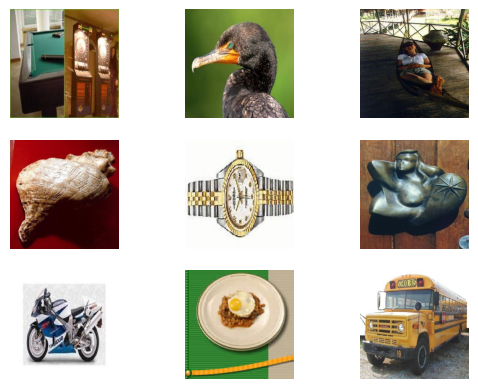

In [ ]:
for i, (image) in enumerate(train_generator):
    if i >= 9 :
        break
    ax = plt.subplot(3, 3, i + 1)
    print(np.shape(image[0]), np.shape(image[0][i]))
    temp = image[0][i] / 255.0
    plt.imshow(temp)
    plt.axis("off")
plt.show()

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## 3. 모델 학습

### 학습률을 위한 과정
1. 전이학습
2. 파인튜닝
3. Cosine Decay 학습률 감쇄
4. 가중치 제한

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L

### 전이학습용 모델 (Epoch 1 ~ 4)

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    model = EfficientNetV2M(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    # 입력 레이어 추가
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    # 드롭아웃
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred",
                           kernel_regularizer=regularizers.l2(0.001),
                           activity_regularizer=regularizers.l1(0.001),
                           kernel_constraint=MaxNorm(2.))(x)

    # 학습률 감쇄 함수
    first_decay_steps = 300
    initial_lr = 1e-3 # 학습률 (1e-3|1e-4|1e-5)
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=initial_lr, first_decay_steps=first_decay_steps))

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=lr_decayed_fn)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### 파인튜닝용 후반 모델 수정 (Epoch 5 ~ 10)

In [ ]:
def unfreeze_model(model):
    for layer in model.layers[-15:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    first_decay_steps = 500
    initial_lr = 1e-4

    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=initial_lr, first_decay_steps=first_decay_steps))
    optimizer = keras.optimizers.Adam(learning_rate=lr_decayed_fn)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

### 모델 학습 및 진행

In [80]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 4

steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size

hist1 = model.fit(train_generator, epochs=epochs,
                 validation_data=test_generator, steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps, verbose=1)

unfreeze_model(model)
epochs = 6
hist2 = model.fit(train_generator, epochs=epochs,
                 validation_data=test_generator, steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps, verbose=1)

Epoch 1/4
398/398 [==============================] - 505s 1s/step - loss: 1.7268 - accuracy: 0.7256 - val_loss: 0.9924 - val_accuracy: 0.8542
Epoch 2/4
398/398 [==============================] - 496s 1s/step - loss: 0.8966 - accuracy: 0.8666 - val_loss: 0.7961 - val_accuracy: 0.8883
Epoch 3/4
398/398 [==============================] - 498s 1s/step - loss: 0.7466 - accuracy: 0.8942 - val_loss: 0.7788 - val_accuracy: 0.8859
Epoch 4/4
398/398 [==============================] - 495s 1s/step - loss: 0.6330 - accuracy: 0.9108 - val_loss: 0.6968 - val_accuracy: 0.8975
Epoch 1/6
398/398 [==============================] - 513s 1s/step - loss: 0.4913 - accuracy: 0.9426 - val_loss: 0.6298 - val_accuracy: 0.9088
Epoch 2/6
398/398 [==============================] - 500s 1s/step - loss: 0.4477 - accuracy: 0.9530 - val_loss: 0.6135 - val_accuracy: 0.9076
Epoch 3/6
398/398 [==============================] - 496s 1s/step - loss: 0.4175 - accuracy: 0.9589 - val_loss: 0.5964 - val_accuracy: 0.9098
Epoch 

### 모델 학습 진행 시각화

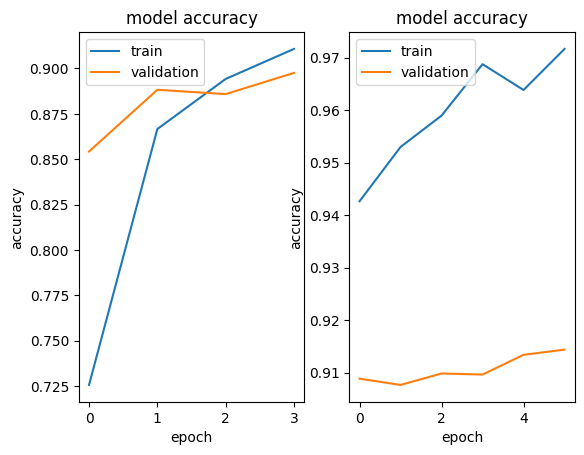

In [81]:
plt.subplot(1,2,1)
plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### 정확도 측정

In [82]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

79/79 [==============================] - 73s 926ms/step - loss: 0.5603 - accuracy: 0.9144
Test loss: 0.5603
Test accuracy: 0.9144
